In [147]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math

In [148]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [149]:
with open('../../filelists/hgg_files.txt', 'r') as f:
    hgg_files = [line.strip() for line in f]

In [150]:
hgg = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/signal/hgg/' + hgg_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hgg"},
).events()

In [189]:
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    #subjets = cluster.exclusive_jets(n_jets=3)
    subjets = cluster.inclusive_jets()
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j = ak.unzip(ak.combinations(vec, 2))
    best = ak.argmax(abs((i + j).mass), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].mass, j[best].mass], axis=1)
    leading = ak.argmax(order_check, axis=1, keepdims=True)
    subleading = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best]], axis=1)
    cut = ((vec.idx != ak.firsts(leading_particles.idx)) & 
       (vec.idx != ak.firsts(ak.sort(leading_particles.idx, ascending=False)))
      )
    everything_else = vec[cut]
    total_soft_pt = ak.sum(everything_else.pt, axis=1)
    everything_else['momentum_fraction'] = (everything_else.pt)/total_soft_pt
    everything_else['weighted_eta'] = everything_else.eta * everything_else.momentum_fraction
    everything_else['weighted_phi'] = everything_else.phi * everything_else.momentum_fraction
    weighted_average_eta = ak.sum(everything_else.weighted_eta, axis=1)/ak.num(everything_else, axis=1)
    average_eta = ak.sum(everything_else.eta, axis=1)/ak.num(everything_else, axis=1)
    weighted_average_phi = ak.sum(everything_else.weighted_phi, axis=1)/ak.num(everything_else, axis=1)
    average_phi = ak.sum(everything_else.phi, axis=1)/ak.num(everything_else, axis=1)
    leg1 = leading_particles[leading]
    leg2 = leading_particles[subleading]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    a13 = (((leg1.eta - average_eta)**2) + 
       ((leg1.phi - average_phi)**2)
      )
    a23 = (((leg2.eta - average_eta)**2) + 
           ((leg2.phi - average_phi)**2)
          )
    a12 = leg1.delta_r2(leg2)
    color_ring = (a13 + a23) / (a12)

    return ak.Array({"cr":color_ring, "hp0_eta":leg1.eta, "hp1_eta":leg2.eta, "se_eta":average_eta,
                "hp0_phi":leg1.phi, "hp1_phi":leg2.phi, "se_phi":average_phi,
                #"hp0_pt":leg1.pt, "hp1_pt":leg2.pt, "se_pt":leg3.pt
                    })

In [190]:
#Make gen particle array
genpart = hgg.GenPart
index = (genpart.pdgId == 25) & (genpart.hasFlags(['isLastCopy', 'fromHardProcess'])) #filter for Higgs
assert ak.all(ak.num(genpart[index],axis=1)==1) #guarantee only one higgs
higgses = ak.flatten(genpart[index], axis=1)
assert ak.all(abs(higgses.children.pdgId) == 21) #guarantee all higgs decay to desired product

In [191]:
#filter fatjets for higgs jets
parents = hgg.FatJet.nearest(higgses, threshold=0.4)
higgs_jets = ~ak.is_none(parents, axis=1)
higgs_fatjet = hgg.FatJet[higgs_jets]

In [192]:
cr_arr = color_ring(higgs_fatjet, cluster_val=0.2) #output color ring and chosen subjets
uf_cr = ak.unflatten(cr_arr['cr'], counts=ak.num(higgs_fatjet)) #unflatten color ring to  event structure
uf_hp0_eta = ak.unflatten(cr_arr['hp0_eta'], counts=ak.num(higgs_fatjet))
uf_hp0_phi = ak.unflatten(cr_arr['hp0_phi'], counts=ak.num(higgs_fatjet))
#uf_hp0_pt = ak.unflatten(cr_arr['hp0_pt'], counts=ak.num(higgs_fatjet))
uf_hp1_eta = ak.unflatten(cr_arr['hp1_eta'], counts=ak.num(higgs_fatjet))
uf_hp1_phi = ak.unflatten(cr_arr['hp1_phi'], counts=ak.num(higgs_fatjet))
#uf_hp1_pt = ak.unflatten(cr_arr['hp1_pt'], counts=ak.num(higgs_fatjet))
uf_se_eta = ak.unflatten(cr_arr['se_eta'], counts=ak.num(higgs_fatjet))
uf_se_phi = ak.unflatten(cr_arr['se_phi'], counts=ak.num(higgs_fatjet))
#uf_se_pt = ak.unflatten(cr_arr['se_pt'], counts=ak.num(higgs_fatjet))

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [193]:
all_vals = ak.zip({'higgses':higgses, 'cr':uf_cr,
        'hp0_eta':uf_hp0_eta, 'hp0_phi':uf_hp0_phi, #'hp0_pt':uf_hp0_pt,
        'hp1_eta':uf_hp1_eta, 'hp1_phi':uf_hp1_phi, #'hp1_pt':uf_hp1_pt,
        'se_eta':uf_se_eta, 'se_phi':uf_se_phi, #'se_pt':uf_se_pt,
       'idx':np.linspace(0, len(higgs_fatjet)-1, len(higgs_fatjet), dtype='int'),
                  })

In [209]:
choose = 1
cut = ((higgses.pt>300) & 
       (abs(higgses.phi)<1) & 
       (abs(higgses.eta)<2.5))
higgs = all_vals['higgses'][cut][choose][0]

In [210]:
xy = np.array([higgs.children.eta, higgs.children.phi])
midpoint_eta = (xy[0,0] + xy[0,1])/2
midpoint_phi = (xy[1,0] + xy[1,1])/2
radius = math.sqrt((xy[0,1] - xy[0,0])**2 + (xy[1,1] - xy[1,0])**2)/2 #distance formula to find color ring radius 
pt = higgs.children.children.pt
#choose leading Pt second gen child
biggest_2 = ak.argmax(pt, axis=1)
use = ak.argmax(ak.Array([pt[0, biggest_2[0]], pt[1, biggest_2[1]]]))
idx = biggest_2[use]
largest_eta = higgs.children[use].children[idx].eta
largest_phi = higgs.children[use].children[idx].phi
largest_pt = higgs.children[use].children[idx].pt

In [211]:
#Coordinates of the subjets chosen for the color Ring Calculation
hp0_eta = all_vals['hp0_eta'][cut][choose][0]
hp1_eta = all_vals['hp1_eta'][cut][choose][0]
se_eta = all_vals['se_eta'][cut][choose][0]
hp0_phi = all_vals['hp0_phi'][cut][choose][0]
hp1_phi = all_vals['hp1_phi'][cut][choose][0]
se_phi = all_vals['se_phi'][cut][choose][0]

In [212]:
pfcands_eta = higgs_fatjet.constituents.pf.eta
pfcands_phi = higgs_fatjet.constituents.pf.phi

In [213]:
all_vals['idx'][cut][choose][0]
pfcands_eta = pfcands_eta[all_vals['idx'][cut][choose][0]][0]
pfcands_phi = pfcands_phi[all_vals['idx'][cut][choose][0]][0]

Text(0.5, 1.0, 'Higgs to GluGlu Jet')

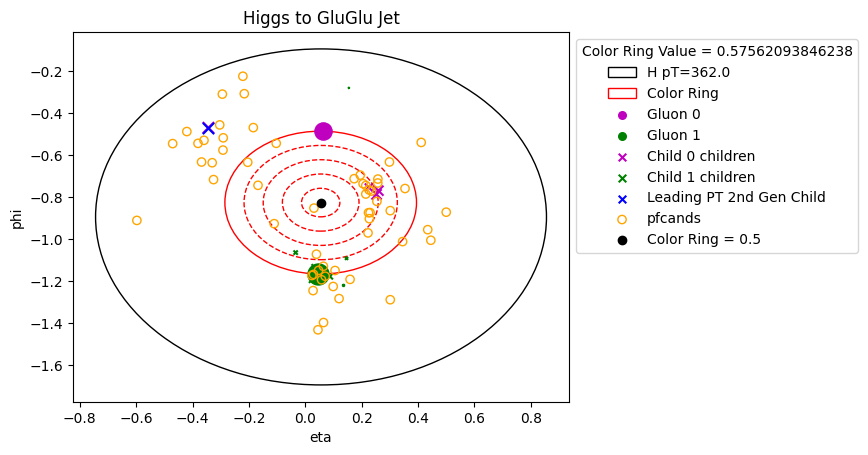

In [214]:
# Gen Particles and children, including the gluon
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label=f"H pT={higgs.pt}"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.scatter(higgs.children[0].eta, higgs.children[0].phi, 
           s=higgs.children[0].pt, 
           label="Gluon 0", color='m')
ax.scatter(higgs.children[1].eta, higgs.children[1].phi, 
           s=higgs.children[1].pt, 
           label="Gluon 1", color='g')
ax.scatter(higgs.children[0].children.eta, higgs.children[0].children.phi, 
           s=higgs.children[0].children.pt, 
           marker="x", label="Child 0 children", color='m')
ax.scatter(higgs.children[1].children.eta, higgs.children[1].children.phi, 
           s=higgs.children[1].children.pt, 
           marker="x", label="Child 1 children", color='g')
ax.scatter(largest_eta, largest_phi, 
           s=largest_pt, 
           marker="x", color='b', label='Leading PT 2nd Gen Child')
# ax.scatter(glu_eta, glu_phi, 
#            #s=glu_pt, 
#            marker="o", color='k', label='Emitted Gluon',facecolors='none')
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.scatter(midpoint_eta, midpoint_phi, label='Color Ring = 0.5', color='k')
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose][0]))
lgnd.legend_handles[1]._sizes = [30]
lgnd.legend_handles[2]._sizes = [30]
lgnd.legend_handles[3]._sizes = [30]
lgnd.legend_handles[4]._sizes = [30]
lgnd.legend_handles[5]._sizes = [30]
lgnd.legend_handles[6]._sizes = [30]
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Higgs to GluGlu Jet')

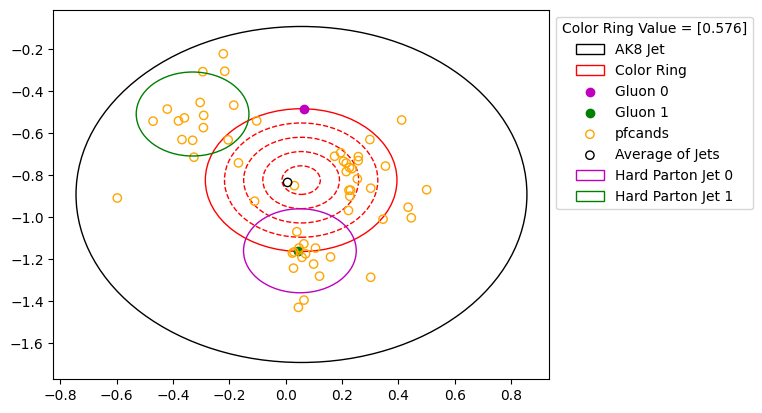

In [215]:
#First gen children and the selected subjets
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label="AK8 Jet"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.scatter(higgs.children[0].eta, higgs.children[0].phi, 
           #s=higgs.children[0].pt, 
           label="Gluon 0", color='m')
ax.scatter(higgs.children[1].eta, higgs.children[1].phi, 
           #s=higgs.children[1].pt, 
           label="Gluon 1", color='g')
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
# ax.scatter(glu_eta, glu_phi, 
#            #s=glu_pt, 
#            marker="o", color='k', label='Emitted Gluon',facecolors='none')
ax.scatter(se_eta, se_phi, 
           marker="o", color='k', label='Average of Jets',facecolors='none')
ax.add_patch(plt.Circle((hp0_eta, hp0_phi), 0.2, facecolor='none', edgecolor='m', label='Hard Parton Jet 0'))
ax.add_patch(plt.Circle((hp1_eta, hp1_phi), 0.2, facecolor='none', edgecolor='g', label='Hard Parton Jet 1'))
# ax.add_patch(plt.Circle((se_eta, se_phi), 0.2, facecolor='none', edgecolor='k', label='Soft Emission Jet'))
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose]))

In [201]:
hp0_phi

-0.31718009676984815